# Anomaly Detection in Congressional Stock Trading
## Master's Thesis - Big Data & Machine Learning
### Universidad de San Andrés

---

## Overview

This notebook implements a rigorous anomaly detection pipeline to identify potentially suspicious trades by U.S. Congress members. We follow methodological best practices from:

- **Liu et al. (2008)**: Isolation Forest
- **Breunig et al. (2000)**: Local Outlier Factor (LOF)
- **Mazzarisi et al. (2022)**: Unsupervised detection in Italian market
- **Neupane & Griva (2024)**: Random Forest for insider trading

**Key methodological features:**
1. Proper data quality assessment and feature selection
2. PCA for dimensionality reduction -> OMITTED
3. Multiple anomaly detection algorithms with hyperparameter tuning
4. Cross-validation for contamination rate selection
5. Ensemble approach (consensus across methods)
6. Validation via CAR analysis

---

## 0. Setup & Dependencies

In [1]:
# Core
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.lines import Line2D

# Stats
from scipy import stats
from scipy.stats import ks_2samp, mannwhitneyu

# Preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer

# Anomaly Detection
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.covariance import EllipticEnvelope

# Model Selection & Evaluation
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import silhouette_score

# ============================================================
# PLOT STYLE - Publication Quality
# ============================================================
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': True,
    'grid.alpha': 0.3,
    'grid.linestyle': '--',
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.family': 'serif',
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 11,
    'figure.dpi': 120,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight'
})

COLORS = {
    'primary': '#2C3E50',
    'secondary': '#7F8C8D',
    'accent': '#E74C3C',
    'success': '#27AE60',
    'warning': '#F39C12',
    'dem': '#3498DB',
    'rep': '#E74C3C',
    'normal': '#95A5A6',
    'anomaly': '#E74C3C'
}

# Reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Setup complete")

✅ Setup complete


## 1. Data Loading

In [2]:
# Load the dataset with all features
# Update this path to your actual file location
df_raw = pd.read_csv('data/outputs/congress_trading_features_FIXED.csv')

print(f"Loaded: {df_raw.shape[0]:,} trades, {df_raw.shape[1]} variables")
print(f"Date range: {df_raw['Traded'].min()} to {df_raw['Traded'].max()}")

Loaded: 108,759 trades, 66 variables
Date range: 2012-06-06 to 2026-01-12


## 2. Data Quality Assessment

Following best practices: examine types, missing values, and distributions before modeling.

### 2.1 Variable Types

In [3]:
# Identify variable types
print(f"{'Variable':<30} {'Type':<15} {'Non-null':>10} {'Sample Value'}")
print("="*80)

for col in df_raw.columns:
    dtype = str(df_raw[col].dtype)
    non_null = df_raw[col].notna().sum()
    sample = df_raw[col].dropna().iloc[0] if df_raw[col].notna().any() else 'ALL NA'
    sample_str = str(sample)[:25] + '...' if len(str(sample)) > 25 else str(sample)
    print(f"{col:<30} {dtype:<15} {non_null:>10,} {sample_str}")

Variable                       Type              Non-null Sample Value
Ticker                         str                108,759 SWK
TickerType                     str                 43,587 Stock
Company                        str                108,748 Stanley Black & Decker In...
Traded                         str                108,759 2026-01-12
Transaction                    str                108,759 Purchase
Trade_Size_USD                 str                108,759 $15,001 - $50,000
Status                         str                 56,380 New
Subholding                     str                 35,176  DAVID TAYLOR TRUST > SAR...
Description                    str                  5,473 PART OF MONTHLY PORTFOLIO...
Name                           str                108,759 Peters, Gary
BioGuideID                     str                108,759 P000595
Filed                          str                108,759 2026-01-20
Party                          str                108,759 D
Di

### 2.2 Missing Values Analysis

In [4]:
# Calculate missing percentages
missing_pct = (df_raw.isna().sum() / len(df_raw) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'variable': missing_pct.index,
    'pct_missing': missing_pct.values,
    'pct_valid': 100 - missing_pct.values
})

# Show variables with missing data
print("Variables with missing data:")
print(missing_df[missing_df['pct_missing'] > 0].head(30).to_string(index=False))

Variables with missing data:
           variable  pct_missing  pct_valid
        Description    94.967773   5.032227
              error    83.768700  16.231300
         Subholding    67.656930  32.343070
         TickerType    59.923317  40.076683
           District    58.279315  41.720685
           Comments    51.300582  48.699418
             Status    48.160612  51.839388
       ev_to_ebitda    30.131759  69.868241
      price_to_book    21.420756  78.579244
         book_value    21.278239  78.721761
         market_cap    21.203762  78.796238
              price    20.540829  79.459171
      momentum_252d    19.818130  80.181870
  realized_vol_252d    19.812613  80.187387
        car_ff3_90d    19.713311  80.286689
       car_capm_90d    19.713311  80.286689
       car_capm_60d    19.545969  80.454031
        car_ff3_60d    19.545969  80.454031
        car_raw_90d    19.350123  80.649877
        car_ff3_30d    19.294955  80.705045
       car_capm_30d    19.274727  80.725273
   

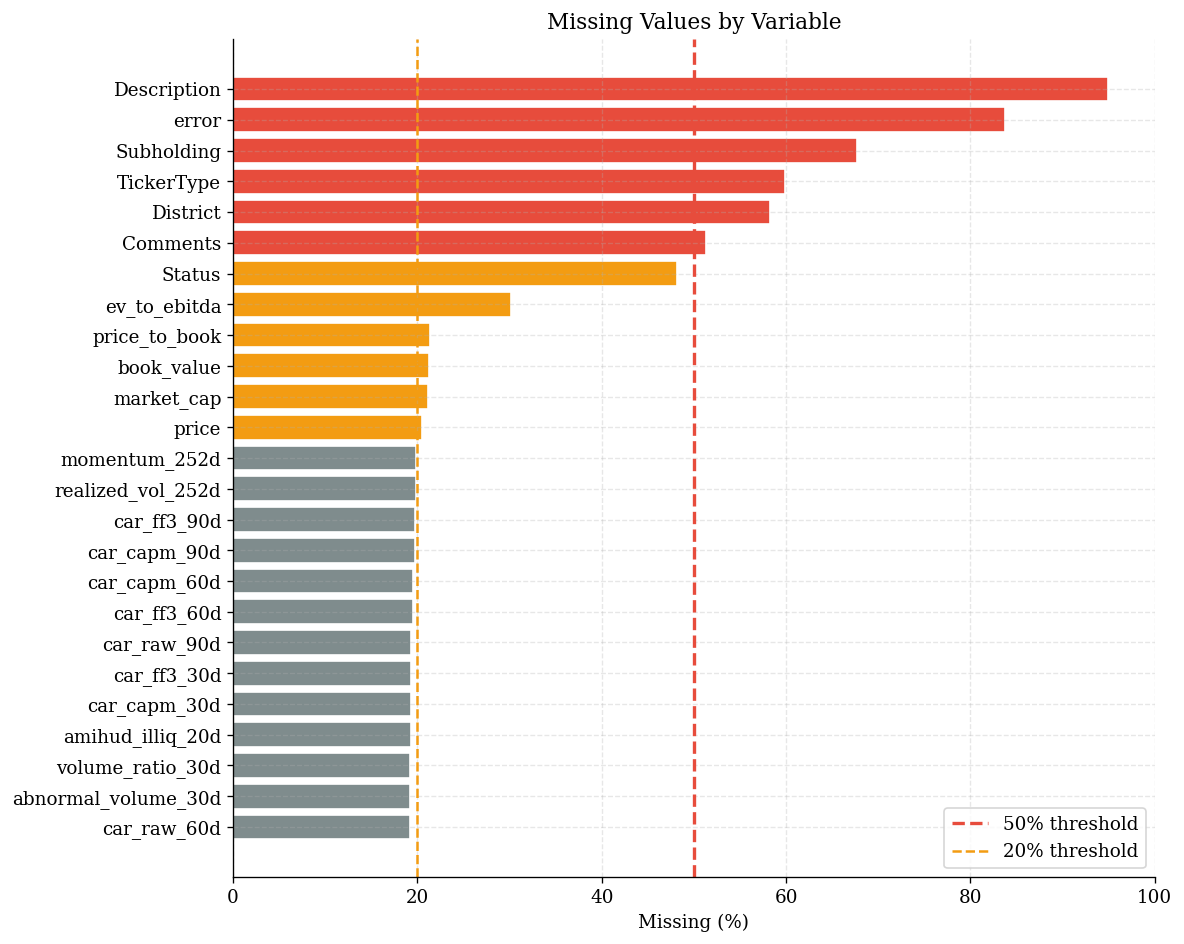

In [5]:
# Visualize missing values
vars_with_missing = missing_df[missing_df['pct_missing'] > 0].head(25)

if len(vars_with_missing) > 0:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = [COLORS['accent'] if x > 50 else COLORS['warning'] if x > 20 else COLORS['secondary'] 
              for x in vars_with_missing['pct_missing']]
    
    bars = ax.barh(vars_with_missing['variable'], vars_with_missing['pct_missing'], 
                   color=colors, edgecolor='white')
    
    ax.axvline(50, color=COLORS['accent'], linestyle='--', linewidth=2, label='50% threshold')
    ax.axvline(20, color=COLORS['warning'], linestyle='--', linewidth=1.5, label='20% threshold')
    
    ax.set_xlabel('Missing (%)')
    ax.set_title('Missing Values by Variable')
    ax.legend(loc='lower right')
    ax.set_xlim(0, 100)
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.savefig('fig_01_missing_values.png', dpi=300)
    plt.show()

### 2.3 Define Feature Sets

In [6]:
# ============================================================
# FEATURE DEFINITIONS
# Grouped by theoretical relevance for insider trading detection
# ============================================================

# Returns & Momentum (timing advantage)
RETURN_FEATURES = [
    'return_t', 'abs_return_t', 'return_overnight', 'return_intraday',
    'momentum_5d', 'momentum_20d', 'momentum_60d', 'momentum_252d'
]

# Volatility (information uncertainty)
VOLATILITY_FEATURES = [
    'realized_vol_30d', 'parkinson_vol_30d', 'realized_vol_60d',
    'vol_of_vol_60d', 'realized_vol_252d'
]

# Volume & Liquidity (trading impact)
VOLUME_FEATURES = [
    'volume_t', 'dollar_volume_t', 'volume_ratio_30d', 'abnormal_volume_30d',
    'amihud_illiq_20d', 'roll_spread_30d', 'hl_spread_20d', 'zero_volume_days_30d'
]

# Risk factors (systematic exposure)
FACTOR_FEATURES = [
    'beta_252d', 'r2_market_252d',
    'alpha_ff3_252d', 'beta_mkt_ff3_252d', 'beta_smb_ff3_252d', 'beta_hml_ff3_252d'
]

# Fundamentals (valuation)
FUNDAMENTAL_FEATURES = [
    'market_cap', 'price', 'book_value', 'price_to_book', 'ev_to_ebitda'
]

# CAR (outcome - for validation only, NOT for detection)
CAR_FEATURES = [
    'car_raw_30d', 'car_capm_30d', 'car_ff3_30d',
    'car_raw_60d', 'car_capm_60d', 'car_ff3_60d',
    'car_raw_90d', 'car_capm_90d', 'car_ff3_90d'
]

# ID columns
ID_COLS = ['trade_id', 'Name', 'Ticker', 'Ticker_Clean', 'Traded', 'Party', 
           'Chamber', 'Transaction', 'Trade_Size_USD']

# All potential model features (excluding CAR which is outcome)
ALL_FEATURES = (RETURN_FEATURES + VOLATILITY_FEATURES + VOLUME_FEATURES + 
                FACTOR_FEATURES + FUNDAMENTAL_FEATURES)

print(f"Total potential features: {len(ALL_FEATURES)}")
print(f"  Returns: {len(RETURN_FEATURES)}")
print(f"  Volatility: {len(VOLATILITY_FEATURES)}")
print(f"  Volume: {len(VOLUME_FEATURES)}")
print(f"  Factors: {len(FACTOR_FEATURES)}")
print(f"  Fundamentals: {len(FUNDAMENTAL_FEATURES)}")

Total potential features: 32
  Returns: 8
  Volatility: 5
  Volume: 8
  Factors: 6
  Fundamentals: 5


In [7]:
# ============================================================
# FILTER FEATURES BY DATA AVAILABILITY
# Keep features with >50% valid data
# ============================================================

MIN_VALID_PCT = 50

features_available = []
features_dropped = []

print(f"{'Feature':<30} {'Valid %':>10} {'Status':<10}")
print("="*55)

for feat in ALL_FEATURES:
    if feat in df_raw.columns:
        pct_valid = df_raw[feat].notna().mean() * 100
        if pct_valid >= MIN_VALID_PCT:
            features_available.append(feat)
            status = '✓ Keep'
        else:
            features_dropped.append(feat)
            status = '✗ Drop'
        print(f"{feat:<30} {pct_valid:>9.1f}% {status:<10}")
    else:
        print(f"{feat:<30} {'NOT FOUND':>10}")

print(f"\n→ Features available for model: {len(features_available)}")
print(f"→ Features dropped (<{MIN_VALID_PCT}% valid): {len(features_dropped)}")

Feature                           Valid % Status    
return_t                            81.3% ✓ Keep    
abs_return_t                        81.3% ✓ Keep    
return_overnight                    81.3% ✓ Keep    
return_intraday                     81.3% ✓ Keep    
momentum_5d                         81.3% ✓ Keep    
momentum_20d                        81.1% ✓ Keep    
momentum_60d                        80.9% ✓ Keep    
momentum_252d                       80.2% ✓ Keep    
realized_vol_30d                    81.1% ✓ Keep    
parkinson_vol_30d                   81.1% ✓ Keep    
realized_vol_60d                    80.9% ✓ Keep    
vol_of_vol_60d                      80.9% ✓ Keep    
realized_vol_252d                   80.2% ✓ Keep    
volume_t                            81.3% ✓ Keep    
dollar_volume_t                     81.3% ✓ Keep    
volume_ratio_30d                    80.8% ✓ Keep    
abnormal_volume_30d                 80.8% ✓ Keep    
amihud_illiq_20d                    80.7% ✓ Ke

### 2.4 Correlation Analysis

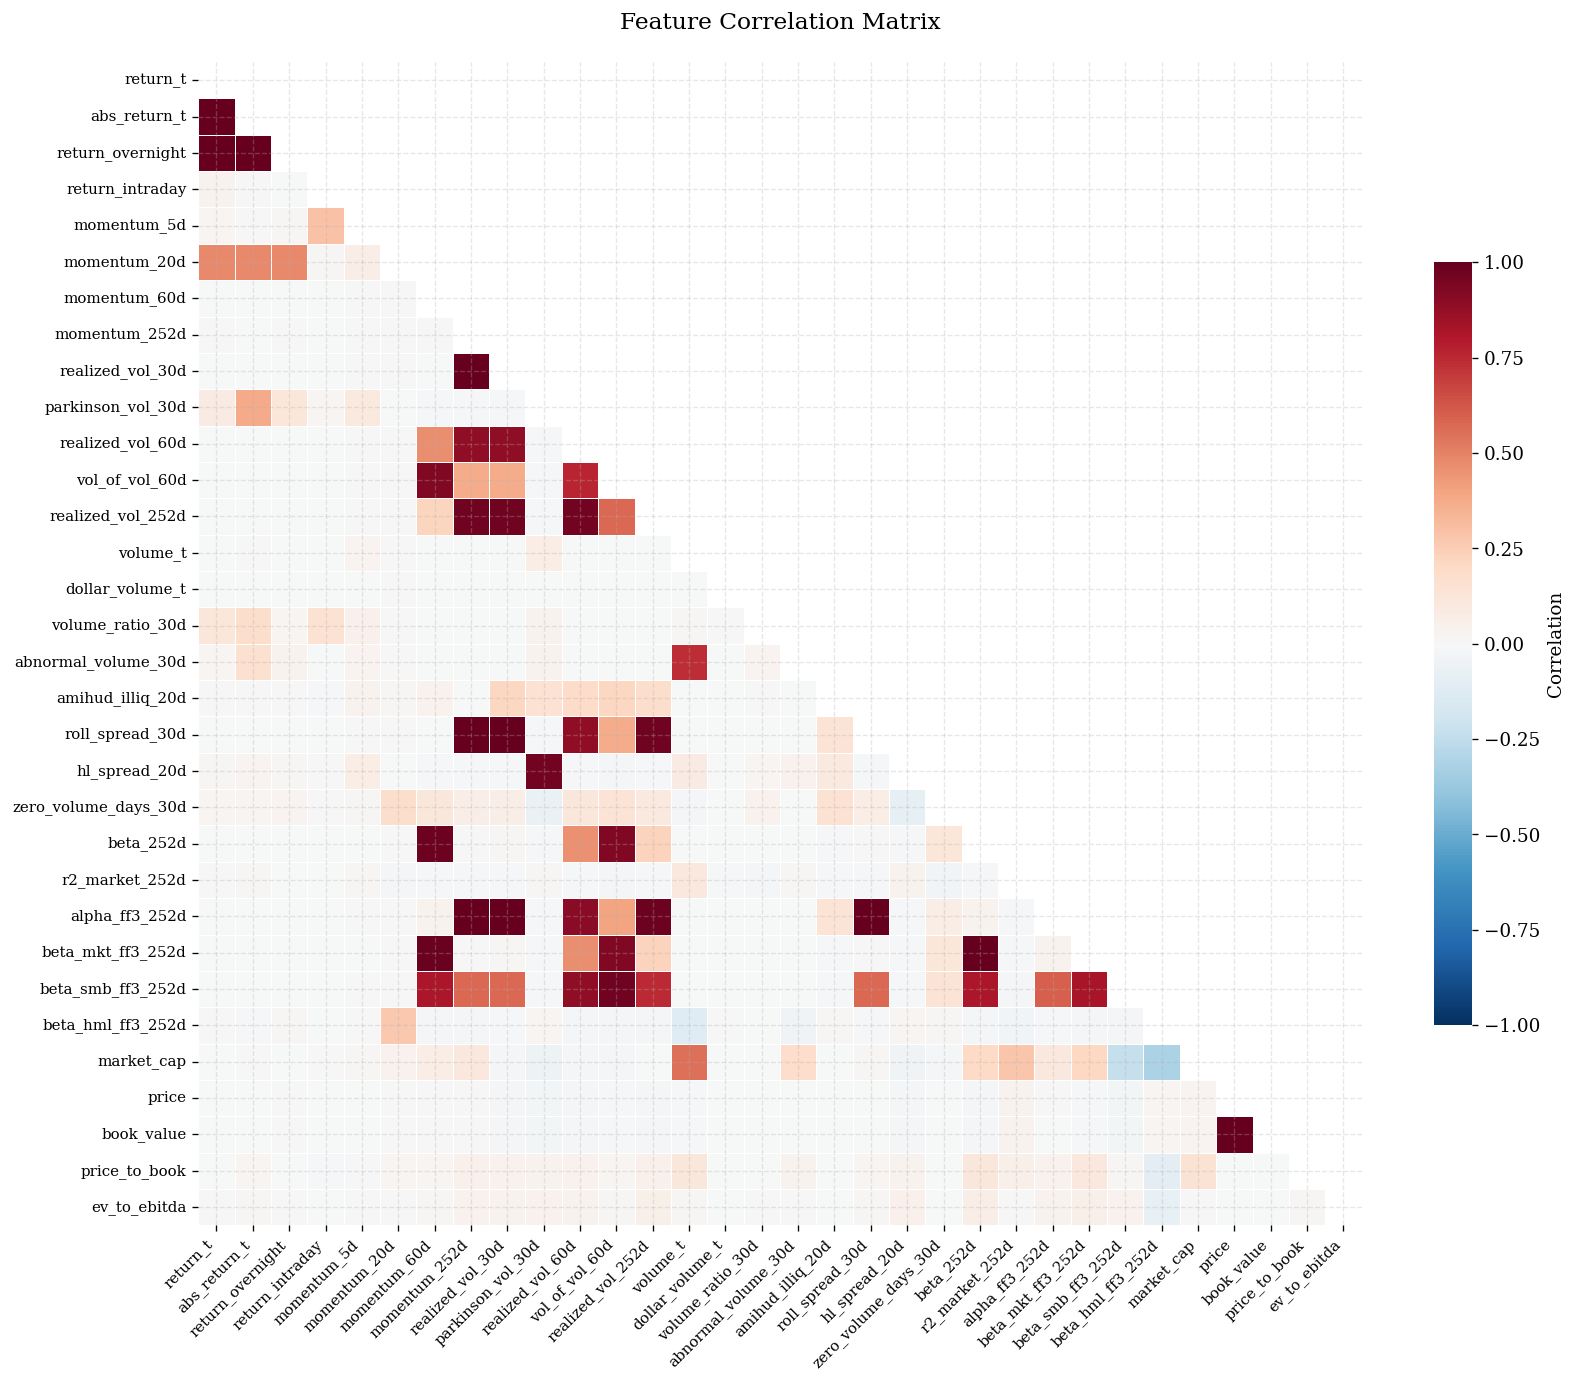

In [8]:
# Correlation matrix for available features
corr_matrix = df_raw[features_available].corr()

# Plot
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

sns.heatmap(corr_matrix, mask=mask, cmap='RdBu_r', center=0,
            square=True, linewidths=0.5, vmin=-1, vmax=1,
            cbar_kws={'shrink': 0.6, 'label': 'Correlation'},
            annot=False, ax=ax)

ax.set_title('Feature Correlation Matrix', fontsize=14, pad=20)
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.yticks(fontsize=9)

plt.tight_layout()
plt.savefig('fig_02_correlation_matrix.png', dpi=300)
plt.show()

In [9]:
# Identify highly correlated pairs (|r| > 0.8)
HIGH_CORR_THRESHOLD = 0.8

high_corr_pairs = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        r = corr_matrix.iloc[i, j]
        if abs(r) > HIGH_CORR_THRESHOLD:
            high_corr_pairs.append({
                'var1': corr_matrix.columns[i],
                'var2': corr_matrix.columns[j],
                'correlation': round(r, 3)
            })

if high_corr_pairs:
    print(f"Highly correlated pairs (|r| > {HIGH_CORR_THRESHOLD}):")
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('correlation', key=abs, ascending=False)
    print(high_corr_df.to_string(index=False))
    print("\n→ Consider keeping only one from each pair, or use PCA")
else:
    print(f"No pairs with |r| > {HIGH_CORR_THRESHOLD}")

Highly correlated pairs (|r| > 0.8):
             var1              var2  correlation
            price        book_value        1.000
        beta_252d beta_mkt_ff3_252d        1.000
 realized_vol_30d   roll_spread_30d        1.000
    momentum_252d   roll_spread_30d        0.999
  roll_spread_30d    alpha_ff3_252d        0.999
         return_t  return_overnight        0.999
    momentum_252d    alpha_ff3_252d        0.999
         return_t      abs_return_t        0.999
     abs_return_t  return_overnight        0.999
 realized_vol_30d    alpha_ff3_252d        0.998
    momentum_252d  realized_vol_30d        0.998
     momentum_60d beta_mkt_ff3_252d        0.985
realized_vol_252d    alpha_ff3_252d        0.981
     momentum_60d         beta_252d        0.979
 realized_vol_30d realized_vol_252d        0.974
    momentum_252d realized_vol_252d        0.974
realized_vol_252d   roll_spread_30d        0.974
   vol_of_vol_60d beta_smb_ff3_252d        0.973
 realized_vol_60d realized_vol_2

### 2.5 Final Feature Selection

In [10]:
# ============================================================
# FINAL FEATURE SET
# Selection criteria:
# 1. >50% data availability
# 2. Avoid redundancy (one per highly correlated family)
# 3. Theoretical relevance for insider trading
# ============================================================

# Manual selection to avoid multicollinearity
# Keep one representative from each correlated family

FEATURES_MODEL = [
    # Returns (key for timing)
    #'return_t',              # Daily return on trade date
    'momentum_5d',           # Short-term momentum
    'momentum_60d',          # Medium-term momentum
    
    # Volatility (one representative)
    'realized_vol_30d',      # 30-day realized volatility
    
    # Volume (key for detection)
    'volume_ratio_30d',      # Relative volume
    'abnormal_volume_30d',   # Abnormal volume
    'amihud_illiq_20d',      # Illiquidity
    
    # Risk
    'beta_252d',             # Market beta
    
    # Fundamentals
    'market_cap',            # Size
    'price_to_book',         # Valuation
]

# Filter to those actually in dataset with sufficient data
FEATURES_MODEL = [f for f in FEATURES_MODEL if f in features_available]

print(f"Final features for model ({len(FEATURES_MODEL)}):")
for i, f in enumerate(FEATURES_MODEL, 1):
    pct = df_raw[f].notna().mean() * 100
    print(f"  {i}. {f}: {pct:.1f}% valid")

Final features for model (9):
  1. momentum_5d: 81.3% valid
  2. momentum_60d: 80.9% valid
  3. realized_vol_30d: 81.1% valid
  4. volume_ratio_30d: 80.8% valid
  5. abnormal_volume_30d: 80.8% valid
  6. amihud_illiq_20d: 80.7% valid
  7. beta_252d: 80.9% valid
  8. market_cap: 78.8% valid
  9. price_to_book: 78.6% valid


## 3. Data Preparation

In [11]:
# ============================================================
# PREPARE MODELING DATASET
# ============================================================

# Keep ID columns + features + CAR for validation
id_cols_available = [c for c in ID_COLS if c in df_raw.columns]
car_cols_available = [c for c in CAR_FEATURES if c in df_raw.columns]

df = df_raw[id_cols_available + FEATURES_MODEL + car_cols_available].copy()

print(f"Before cleaning: {len(df):,} trades")

# Drop rows with missing values in model features
df_model = df.dropna(subset=FEATURES_MODEL).copy()

print(f"After dropping NA in features: {len(df_model):,} trades")
print(f"Retention rate: {len(df_model)/len(df)*100:.1f}%")

Before cleaning: 108,759 trades
After dropping NA in features: 84,986 trades
Retention rate: 78.1%


In [12]:
# ============================================================
# HANDLE INFINITIES AND EXTREME VALUES
# ============================================================

X = df_model[FEATURES_MODEL].copy()

# Replace infinities
X = X.replace([np.inf, -np.inf], np.nan)

# Winsorize extreme values (1st and 99th percentile)
for col in X.columns:
    q01, q99 = X[col].quantile([0.01, 0.99])
    X[col] = X[col].clip(q01, q99)

# Drop any remaining NaN after winsorization
valid_idx = X.dropna().index
X = X.loc[valid_idx]
df_model = df_model.loc[valid_idx]

print(f"Final sample size: {len(df_model):,} trades")
print(f"Feature matrix shape: {X.shape}")

Final sample size: 84,986 trades
Feature matrix shape: (84986, 9)


In [13]:
# Descriptive statistics
X.describe().T.round(4)

,count,mean,std,min,25%,50%,75%,max
momentum_5d,84986.0,-0.0018,5.490000e-02,-1.905000e-01,-0.0263,0.0004,0.0250,1.741000e-01
momentum_60d,84986.0,0.0041,1.691000e-01,-4.599000e-01,-0.0935,0.0024,0.0954,5.683000e-01
realized_vol_30d,84986.0,0.3303,2.084000e-01,9.660000e-02,0.1978,0.2714,0.3833,1.247800e+00
volume_ratio_30d,84986.0,1.1484,6.934000e-01,3.711000e-01,0.7620,0.9716,1.2915,5.153200e+00
abnormal_volume_30d,84986.0,944870.5337,8.532645e+06,-2.467218e+07,-667520.0000,-20081.1000,707783.3333,5.639388e+07
amihud_illiq_20d,84986.0,0.0016,7.400000e-03,0.000000e+00,0.0000,0.0001,0.0002,6.090000e-02
beta_252d,84986.0,0.9971,4.226000e-01,6.250000e-02,0.7268,0.9843,1.2394,2.279500e+00
market_cap,84986.0,313017.4071,8.157251e+05,6.023320e+01,14573.2987,55595.0244,183061.3975,4.093897e+06
price_to_book,84986.0,5.7643,1.415660e+01,-5.927050e+01,1.6177,3.1019,8.1419,6.418800e+01


### 3.1 Scaling

In [14]:
# ============================================================
# ROBUST SCALING
# Uses median and IQR - better for heavy-tailed financial data
# ============================================================

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=FEATURES_MODEL, index=X.index)

print("Post-scaling statistics:")
print(X_scaled.describe().T[['mean', 'std', '50%']].round(3))

Post-scaling statistics:
                      mean     std  50%
momentum_5d         -0.044   1.071  0.0
momentum_60d         0.009   0.895  0.0
realized_vol_30d     0.317   1.123 -0.0
volume_ratio_30d     0.334   1.309 -0.0
abnormal_volume_30d  0.702   6.204  0.0
amihud_illiq_20d     9.245  45.649  0.0
beta_252d            0.025   0.824 -0.0
market_cap           1.528   4.841  0.0
price_to_book        0.408   2.170  0.0


## 4. Anomaly Detection Models

We implement multiple algorithms and use ensemble consensus:

1. **Isolation Forest** (Liu et al., 2008): Global outliers based on isolation depth
2. **Local Outlier Factor** (Breunig et al., 2000): Local density-based outliers
3. **One-Class SVM**: Boundary-based detection
4. **Elliptic Envelope**: Assumes Gaussian distribution

### 4.1 Hyperparameter Selection via Cross-Validation

In [15]:
# ============================================================
# CONTAMINATION RATE SELECTION
# ============================================================

# Convertir a numpy array
X_model = X_scaled.values

# Contamination rates to test
CONTAMINATION_RATES = [0.01, 0.02, 0.03, 0.05, 0.07, 0.10]

# Store results
cv_results = []

print("Testing contamination rates...\n")

for cont in CONTAMINATION_RATES:
    # Isolation Forest
    clf_if = IsolationForest(
        contamination=cont,
        n_estimators=200,
        max_samples='auto',
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    labels_if = clf_if.fit_predict(X_model)
    
    # LOF
    n_neighbors = max(20, int(len(X_model) * 0.01))
    clf_lof = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=cont,
        n_jobs=-1
    )
    labels_lof = clf_lof.fit_predict(X_model)
    
    # One-Class SVM (slower, use subsample for tuning)
    if len(X_model) > 10000:
        idx_sample = np.random.choice(len(X_model), 10000, replace=False)
        X_sample = X_model[idx_sample]
    else:
        X_sample = X_model
    
    clf_svm = OneClassSVM(nu=cont, kernel='rbf', gamma='auto')
    labels_svm_sample = clf_svm.fit_predict(X_sample)
    
    # Agreement between IF and LOF
    agreement = (labels_if == labels_lof).mean()
    
    # Number of anomalies
    n_anom_if = (labels_if == -1).sum()
    n_anom_lof = (labels_lof == -1).sum()
    n_anom_both = ((labels_if == -1) & (labels_lof == -1)).sum()
    
    cv_results.append({
        'contamination': cont,
        'n_anom_if': n_anom_if,
        'n_anom_lof': n_anom_lof,
        'n_anom_consensus': n_anom_both,
        'agreement': agreement
    })
    
    print(f"c={cont:.2f}: IF={n_anom_if:,}, LOF={n_anom_lof:,}, Both={n_anom_both:,}, Agreement={agreement:.1%}")

cv_df = pd.DataFrame(cv_results)
print("\n" + cv_df.to_string(index=False))

Testing contamination rates...

c=0.01: IF=848, LOF=850, Both=55, Agreement=98.1%
c=0.02: IF=1,700, LOF=1,700, Both=184, Agreement=96.4%
c=0.03: IF=2,549, LOF=2,550, Both=304, Agreement=94.7%
c=0.05: IF=4,250, LOF=4,250, Both=715, Agreement=91.7%
c=0.07: IF=5,947, LOF=5,949, Both=1,311, Agreement=89.1%
c=0.10: IF=8,499, LOF=8,499, Both=2,547, Agreement=86.0%

 contamination  n_anom_if  n_anom_lof  n_anom_consensus  agreement
          0.01        848         850                55   0.981315
          0.02       1700        1700               184   0.964324
          0.03       2549        2550               304   0.947156
          0.05       4250        4250               715   0.916810
          0.07       5947        5949              1311   0.890876
          0.10       8499        8499              2547   0.859930


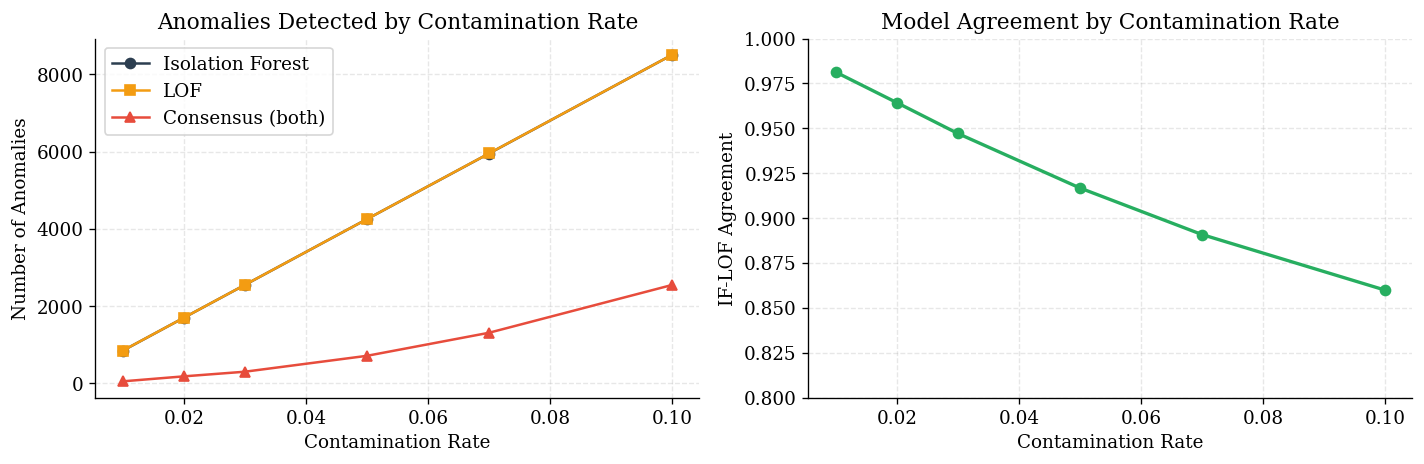

In [16]:
# Visualize contamination selection
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Number of anomalies
axes[0].plot(cv_df['contamination'], cv_df['n_anom_if'], 'o-', label='Isolation Forest', color=COLORS['primary'])
axes[0].plot(cv_df['contamination'], cv_df['n_anom_lof'], 's-', label='LOF', color=COLORS['warning'])
axes[0].plot(cv_df['contamination'], cv_df['n_anom_consensus'], '^-', label='Consensus (both)', color=COLORS['accent'])
axes[0].set_xlabel('Contamination Rate')
axes[0].set_ylabel('Number of Anomalies')
axes[0].set_title('Anomalies Detected by Contamination Rate')
axes[0].legend()

# Agreement
axes[1].plot(cv_df['contamination'], cv_df['agreement'], 'o-', color=COLORS['success'], linewidth=2)
axes[1].set_xlabel('Contamination Rate')
axes[1].set_ylabel('IF-LOF Agreement')
axes[1].set_title('Model Agreement by Contamination Rate')
axes[1].set_ylim(0.8, 1.0)

plt.tight_layout()
plt.savefig('fig_04_contamination_selection.png', dpi=300)
plt.show()

In [17]:
# ============================================================
# SELECT CONTAMINATION RATE
# Criteria: Balance between detection power and conservatism
# ============================================================

# Select contamination with highest agreement (most stable)
# Or use domain knowledge: insider trading is rare (2-5%)
CONTAMINATION = 0.03  # 2% - conservative assumption

print(f"Selected contamination rate: {CONTAMINATION} ({CONTAMINATION*100:.0f}%)")
print(f"Expected anomalies: ~{int(len(X_model) * CONTAMINATION):,}")

Selected contamination rate: 0.03 (3%)
Expected anomalies: ~2,549


### 4.2 Final Model Training

In [18]:
# ============================================================
# ISOLATION FOREST
# ============================================================

clf_if = IsolationForest(
    contamination=CONTAMINATION,
    n_estimators=300,           # More trees for stability
    max_samples='auto',
    max_features=1.0,
    bootstrap=False,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

clf_if.fit(X_model)

# Get scores and labels
df_model['score_if'] = -clf_if.score_samples(X_model)  # Higher = more anomalous
df_model['label_if'] = clf_if.predict(X_model)
df_model['anomaly_if'] = (df_model['label_if'] == -1).astype(int)

n_anom_if = df_model['anomaly_if'].sum()
print(f"Isolation Forest: {n_anom_if:,} anomalies ({n_anom_if/len(df_model)*100:.2f}%)")

Isolation Forest: 2,550 anomalies (3.00%)


In [19]:
# ============================================================
# LOCAL OUTLIER FACTOR (LOF)
# ============================================================

n_neighbors = max(20, int(len(X_model) * 0.01))  # ~1% of data

clf_lof = LocalOutlierFactor(
    n_neighbors=n_neighbors,
    contamination=CONTAMINATION,
    metric='euclidean',
    n_jobs=-1
)

labels_lof = clf_lof.fit_predict(X_model)
scores_lof = -clf_lof.negative_outlier_factor_  # Higher = more anomalous

df_model['score_lof'] = scores_lof
df_model['anomaly_lof'] = (labels_lof == -1).astype(int)

n_anom_lof = df_model['anomaly_lof'].sum()
print(f"LOF (k={n_neighbors}): {n_anom_lof:,} anomalies ({n_anom_lof/len(df_model)*100:.2f}%)")

LOF (k=849): 2,550 anomalies (3.00%)


In [20]:
# ============================================================
# ONE-CLASS SVM
# ============================================================

clf_svm = OneClassSVM(
    nu=CONTAMINATION,
    kernel='rbf',
    gamma='scale'
)

labels_svm = clf_svm.fit_predict(X_model)
scores_svm = -clf_svm.decision_function(X_model)  # Higher = more anomalous

df_model['score_svm'] = scores_svm
df_model['anomaly_svm'] = (labels_svm == -1).astype(int)

n_anom_svm = df_model['anomaly_svm'].sum()
print(f"One-Class SVM: {n_anom_svm:,} anomalies ({n_anom_svm/len(df_model)*100:.2f}%)")

One-Class SVM: 2,553 anomalies (3.00%)


In [21]:
# ============================================================
# ELLIPTIC ENVELOPE (Gaussian assumption)
# ============================================================

try:
    clf_ee = EllipticEnvelope(
        contamination=CONTAMINATION,
        random_state=RANDOM_STATE,
        support_fraction=0.9
    )
    
    labels_ee = clf_ee.fit_predict(X_model)
    scores_ee = -clf_ee.decision_function(X_model)
    
    df_model['score_ee'] = scores_ee
    df_model['anomaly_ee'] = (labels_ee == -1).astype(int)
    
    n_anom_ee = df_model['anomaly_ee'].sum()
    print(f"Elliptic Envelope: {n_anom_ee:,} anomalies ({n_anom_ee/len(df_model)*100:.2f}%)")
    USE_EE = True
except Exception as e:
    print(f"Elliptic Envelope failed: {e}")
    df_model['anomaly_ee'] = 0
    USE_EE = False

Elliptic Envelope: 2,550 anomalies (3.00%)


### 4.3 Ensemble & Consensus

In [22]:
# ============================================================
# ENSEMBLE ANOMALY SCORE
# Normalize and combine scores from all methods
# ============================================================

from sklearn.preprocessing import MinMaxScaler

# Normalize scores to [0, 1]
score_cols = ['score_if', 'score_lof', 'score_svm']
if USE_EE:
    score_cols.append('score_ee')

scaler_scores = MinMaxScaler()
scores_normalized = scaler_scores.fit_transform(df_model[score_cols])

for i, col in enumerate(score_cols):
    df_model[f'{col}_norm'] = scores_normalized[:, i]

# Combined score (average)
df_model['score_ensemble'] = scores_normalized.mean(axis=1)

# Consensus flags
df_model['anomaly_consensus_2'] = (
    (df_model['anomaly_if'] + df_model['anomaly_lof'] + df_model['anomaly_svm']) >= 2
).astype(int)

df_model['anomaly_consensus_3'] = (
    (df_model['anomaly_if'] + df_model['anomaly_lof'] + df_model['anomaly_svm']) >= 3
).astype(int)

# Summary
print("Anomaly Detection Summary:")
print("="*50)
print(f"Isolation Forest:     {df_model['anomaly_if'].sum():>6,} ({df_model['anomaly_if'].mean()*100:.2f}%)")
print(f"LOF:                  {df_model['anomaly_lof'].sum():>6,} ({df_model['anomaly_lof'].mean()*100:.2f}%)")
print(f"One-Class SVM:        {df_model['anomaly_svm'].sum():>6,} ({df_model['anomaly_svm'].mean()*100:.2f}%)")
print(f"Consensus (≥2/3):     {df_model['anomaly_consensus_2'].sum():>6,} ({df_model['anomaly_consensus_2'].mean()*100:.2f}%)")
print(f"Consensus (3/3):      {df_model['anomaly_consensus_3'].sum():>6,} ({df_model['anomaly_consensus_3'].mean()*100:.2f}%)")

Anomaly Detection Summary:
Isolation Forest:      2,550 (3.00%)
LOF:                   2,550 (3.00%)
One-Class SVM:         2,553 (3.00%)
Consensus (≥2/3):      1,526 (1.80%)
Consensus (3/3):          76 (0.09%)


In [23]:
# Model agreement matrix
print("\nPairwise Model Agreement:")
methods = ['anomaly_if', 'anomaly_lof', 'anomaly_svm']
agreement_matrix = pd.DataFrame(index=['IF', 'LOF', 'SVM'], columns=['IF', 'LOF', 'SVM'])

for i, m1 in enumerate(methods):
    for j, m2 in enumerate(methods):
        agreement = (df_model[m1] == df_model[m2]).mean()
        agreement_matrix.iloc[i, j] = f"{agreement:.1%}"

print(agreement_matrix)


Pairwise Model Agreement:
         IF     LOF     SVM
IF   100.0%   94.7%   96.6%
LOF   94.7%  100.0%   94.6%
SVM   96.6%   94.6%  100.0%


## 5. Visualizations

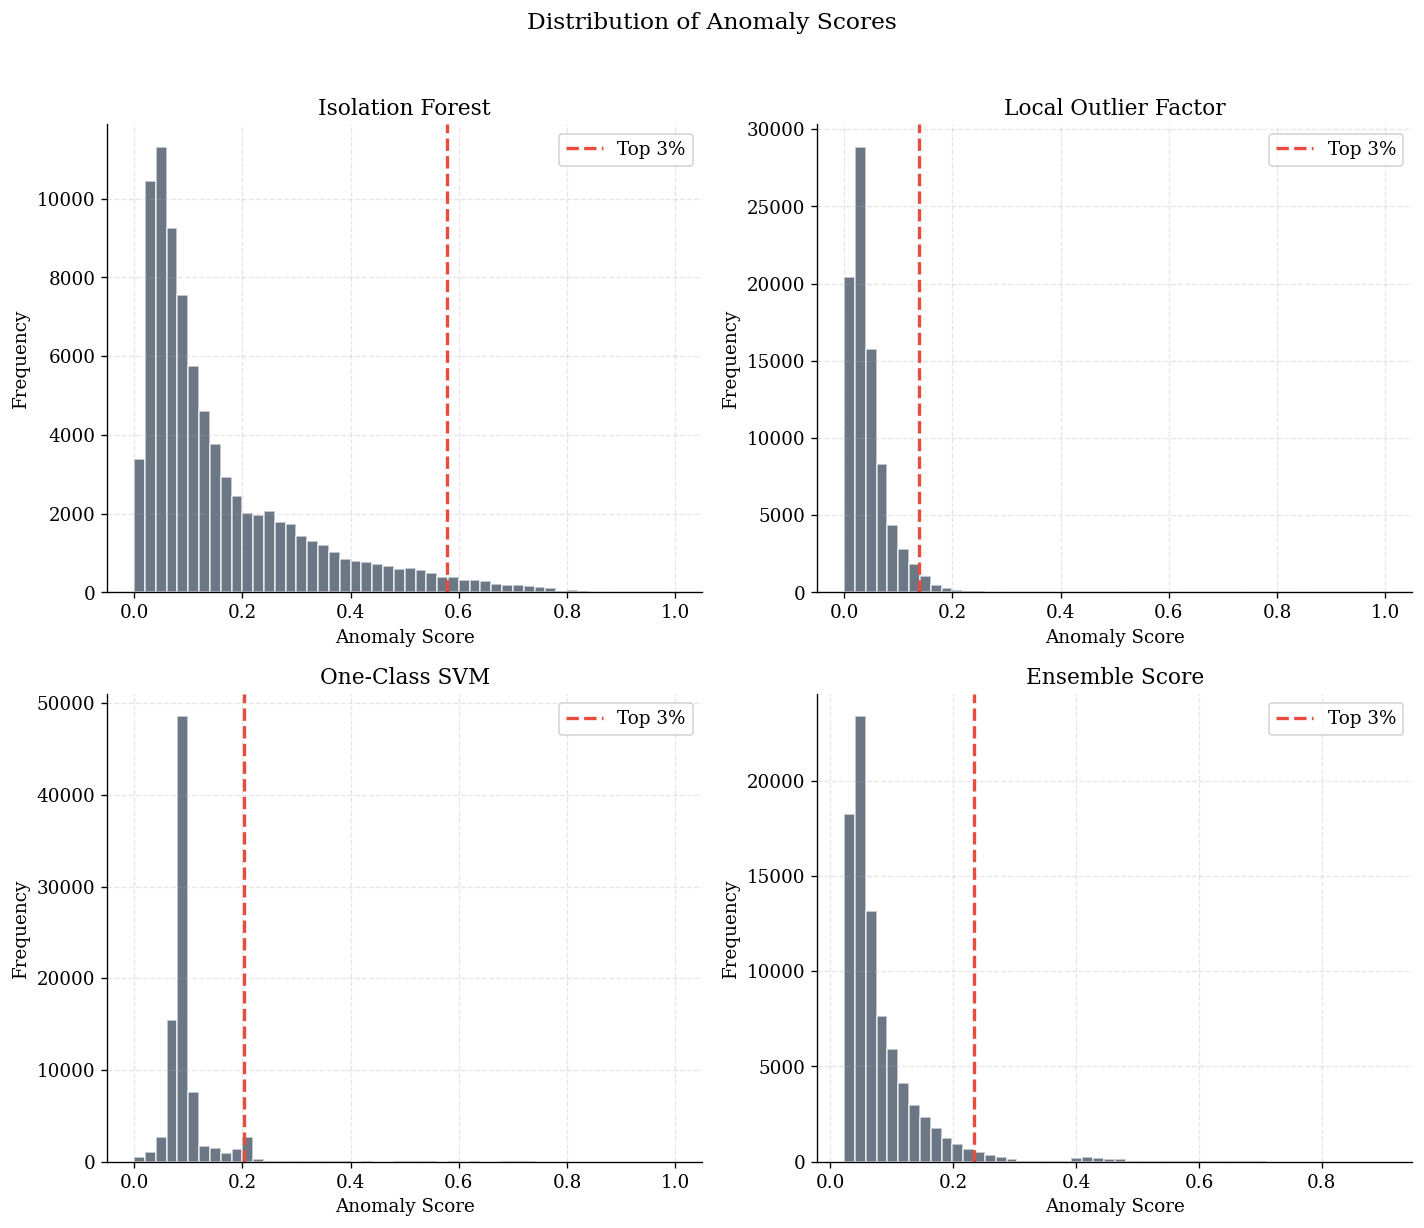

In [24]:
# ============================================================
# FIGURE: Score Distributions
# ============================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 10))

score_data = [
    ('score_if_norm', 'Isolation Forest', axes[0, 0]),
    ('score_lof_norm', 'Local Outlier Factor', axes[0, 1]),
    ('score_svm_norm', 'One-Class SVM', axes[1, 0]),
    ('score_ensemble', 'Ensemble Score', axes[1, 1])
]

for score_col, title, ax in score_data:
    ax.hist(df_model[score_col], bins=50, color=COLORS['primary'], 
            edgecolor='white', alpha=0.7)
    
    # Mark threshold
    threshold = df_model[score_col].quantile(1 - CONTAMINATION)
    ax.axvline(threshold, color=COLORS['accent'], linestyle='--', 
               linewidth=2, label=f'Top {CONTAMINATION*100:.0f}%')
    
    ax.set_xlabel('Anomaly Score')
    ax.set_ylabel('Frequency')
    ax.set_title(title)
    ax.legend()

plt.suptitle('Distribution of Anomaly Scores', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('fig_05_score_distributions.png', dpi=300)
plt.show()

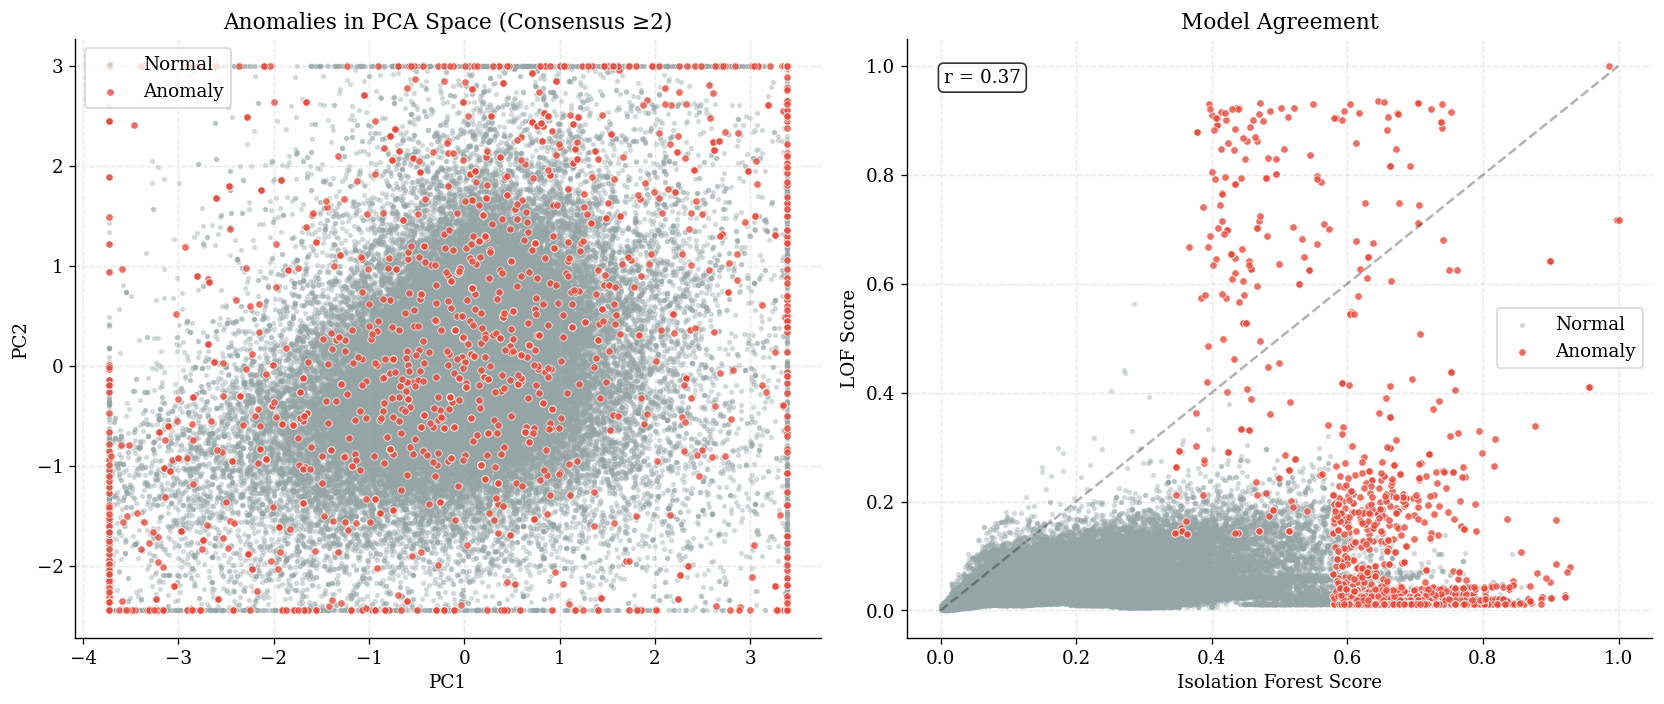

In [25]:
# ============================================================
# FIGURE: PCA Scatter with Anomalies
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# PC1 vs PC2
normal_mask = df_model['anomaly_consensus_2'] == 0
anomaly_mask = df_model['anomaly_consensus_2'] == 1

axes[0].scatter(X_model[normal_mask, 0], X_model[normal_mask, 1], 
                s=5, alpha=0.3, c=COLORS['normal'], label='Normal')
axes[0].scatter(X_model[anomaly_mask, 0], X_model[anomaly_mask, 1], 
                s=20, alpha=0.8, c=COLORS['anomaly'], label='Anomaly', edgecolors='white', linewidth=0.5)
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].set_title('Anomalies in PCA Space (Consensus ≥2)')
axes[0].legend()

# Score comparison: IF vs LOF
axes[1].scatter(df_model.loc[normal_mask, 'score_if_norm'], 
                df_model.loc[normal_mask, 'score_lof_norm'],
                s=5, alpha=0.3, c=COLORS['normal'], label='Normal')
axes[1].scatter(df_model.loc[anomaly_mask, 'score_if_norm'], 
                df_model.loc[anomaly_mask, 'score_lof_norm'],
                s=20, alpha=0.8, c=COLORS['anomaly'], label='Anomaly', edgecolors='white', linewidth=0.5)
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.3)
axes[1].set_xlabel('Isolation Forest Score')
axes[1].set_ylabel('LOF Score')
axes[1].set_title('Model Agreement')
axes[1].legend()

r = df_model['score_if_norm'].corr(df_model['score_lof_norm'])
axes[1].text(0.05, 0.95, f'r = {r:.2f}', transform=axes[1].transAxes, 
             fontsize=11, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('fig_06_pca_anomalies.png', dpi=300)
plt.show()

## 6. Validation via CAR Analysis

**Key hypothesis:** If anomalies represent informed trading, they should exhibit higher cumulative abnormal returns (CAR).

In [26]:
# ============================================================
# CAR COMPARISON: NORMAL vs ANOMALOUS TRADES
# ============================================================

# Use consensus anomalies
anomaly_col = 'anomaly_consensus_2'

# Available CAR columns
car_cols = [c for c in car_cols_available if c in df_model.columns and df_model[c].notna().sum() > 100]

print("CAR Comparison: Normal vs Anomalous Trades")
print("="*70)

results_car = []

for car_col in car_cols:
    normal = df_model[df_model[anomaly_col] == 0][car_col].dropna()
    anomaly = df_model[df_model[anomaly_col] == 1][car_col].dropna()
    
    if len(normal) < 30 or len(anomaly) < 30:
        continue
    
    # Statistics
    mean_normal = normal.mean()
    mean_anomaly = anomaly.mean()
    diff = mean_anomaly - mean_normal
    
    # T-test
    t_stat, p_val_t = stats.ttest_ind(normal, anomaly)
    
    # Mann-Whitney U (non-parametric)
    u_stat, p_val_u = mannwhitneyu(normal, anomaly, alternative='two-sided')
    
    results_car.append({
        'CAR': car_col,
        'Mean_Normal': mean_normal,
        'Mean_Anomaly': mean_anomaly,
        'Difference': diff,
        't_stat': t_stat,
        'p_value_t': p_val_t,
        'p_value_MW': p_val_u,
        'n_normal': len(normal),
        'n_anomaly': len(anomaly)
    })
    
    sig = '***' if p_val_t < 0.01 else '**' if p_val_t < 0.05 else '*' if p_val_t < 0.10 else ''
    print(f"{car_col:<20} Normal: {mean_normal:>8.4f}  Anomaly: {mean_anomaly:>8.4f}  Diff: {diff:>8.4f}  p={p_val_t:.4f} {sig}")

results_car_df = pd.DataFrame(results_car)
print("\n*** p<0.01, ** p<0.05, * p<0.10")

CAR Comparison: Normal vs Anomalous Trades
car_raw_30d          Normal:   0.0006  Anomaly:   0.0572  Diff:   0.0566  p=0.0000 ***
car_capm_30d         Normal:   0.0006  Anomaly:   0.0536  Diff:   0.0530  p=0.0000 ***
car_ff3_30d          Normal:  -0.0015  Anomaly:   0.0522  Diff:   0.0537  p=0.0000 ***
car_raw_60d          Normal:   0.0018  Anomaly:   0.1051  Diff:   0.1034  p=0.0000 ***
car_capm_60d         Normal:   0.0017  Anomaly:   0.0943  Diff:   0.0925  p=0.0000 ***
car_ff3_60d          Normal:  -0.0025  Anomaly:   0.0883  Diff:   0.0908  p=0.0000 ***
car_raw_90d          Normal:   0.0002  Anomaly:   0.1438  Diff:   0.1436  p=0.0000 ***
car_capm_90d         Normal:   0.0007  Anomaly:   0.1257  Diff:   0.1250  p=0.0000 ***
car_ff3_90d          Normal:  -0.0048  Anomaly:   0.1186  Diff:   0.1234  p=0.0000 ***

*** p<0.01, ** p<0.05, * p<0.10


In [27]:
print("Normal CAR 30d:")
print(df_model[df_model['anomaly_consensus_2']==0]['car_raw_30d'].describe())
print("\nAnomaly CAR 30d:")
print(df_model[df_model['anomaly_consensus_2']==1]['car_raw_30d'].describe())

Normal CAR 30d:
count    83452.000000
mean         0.000584
std          0.107009
min         -0.333403
25%         -0.055378
50%         -0.001516
75%          0.051815
max          3.837984
Name: car_raw_30d, dtype: float64

Anomaly CAR 30d:
count    1526.000000
mean        0.057205
std         0.402376
min        -0.333403
25%        -0.076522
50%         0.016568
75%         0.121736
max         6.736371
Name: car_raw_30d, dtype: float64


### Paréntesis: Mini chequeo de si hay sesgo (Ivo)
Lo anterior dio demasiado significativo, de repente alguna variable clave de la prediccón es super colineal al CAR

In [28]:
# Correlación entre momentum y CAR
print(df_model[['momentum_5d', 'momentum_60d', 'car_raw_30d', 'car_raw_60d']].corr())

              momentum_5d  momentum_60d  car_raw_30d  car_raw_60d
momentum_5d      1.000000      0.453616    -0.017307    -0.012615
momentum_60d     0.453616      1.000000     0.000304     0.012399
car_raw_30d     -0.017307      0.000304     1.000000     0.735443
car_raw_60d     -0.012615      0.012399     0.735443     1.000000


In [29]:
# Compará CAR solo en acciones de volatilidad similar
median_vol = df_model['realized_vol_30d'].median()

# Solo acciones de baja volatilidad
low_vol = df_model[df_model['realized_vol_30d'] <= median_vol]
print("LOW VOL:")
print(f"Normal CAR: {low_vol[low_vol['anomaly_consensus_2']==0]['car_raw_30d'].mean():.4f}")
print(f"Anomaly CAR: {low_vol[low_vol['anomaly_consensus_2']==1]['car_raw_30d'].mean():.4f}")

# Solo acciones de alta volatilidad  
high_vol = df_model[df_model['realized_vol_30d'] > median_vol]
print("\nHIGH VOL:")
print(f"Normal CAR: {high_vol[high_vol['anomaly_consensus_2']==0]['car_raw_30d'].mean():.4f}")
print(f"Anomaly CAR: {high_vol[high_vol['anomaly_consensus_2']==1]['car_raw_30d'].mean():.4f}")

LOW VOL:
Normal CAR: -0.0018
Anomaly CAR: -0.0000

HIGH VOL:
Normal CAR: 0.0030
Anomaly CAR: 0.0643


In [38]:
# Comparar features entre normales y anomalías
print("Feature means: Normal vs Anomaly")
print("="*50)
for feat in FEATURES_MODEL:
    normal_mean = df_model[df_model['anomaly_consensus_2']==0][feat].mean()
    anomaly_mean = df_model[df_model['anomaly_consensus_2']==1][feat].mean()
    ratio = anomaly_mean / normal_mean if normal_mean != 0 else np.nan
    print(f"{feat:<25} Normal: {normal_mean:>10.4f}  Anomaly: {anomaly_mean:>10.4f}  Ratio: {ratio:>6.2f}x")

Feature means: Normal vs Anomaly
momentum_5d               Normal:    -0.0016  Anomaly:     0.0462  Ratio: -28.61x
momentum_60d              Normal:     0.0059  Anomaly:     0.1760  Ratio:  29.60x
realized_vol_30d          Normal:     0.3254  Anomaly:     0.8474  Ratio:   2.60x
volume_ratio_30d          Normal:     1.1599  Anomaly:     6.9315  Ratio:   5.98x
abnormal_volume_30d       Normal: 1106122.8343  Anomaly: 44474487.0068  Ratio:  40.21x
amihud_illiq_20d          Normal:     0.0132  Anomaly:     8.9554  Ratio: 679.15x
beta_252d                 Normal:     0.9932  Anomaly:     1.3176  Ratio:   1.33x
market_cap                Normal: 298785.9962  Anomaly: 1310823.7083  Ratio:   4.39x
price_to_book             Normal:     6.0570  Anomaly:    17.8255  Ratio:   2.94x


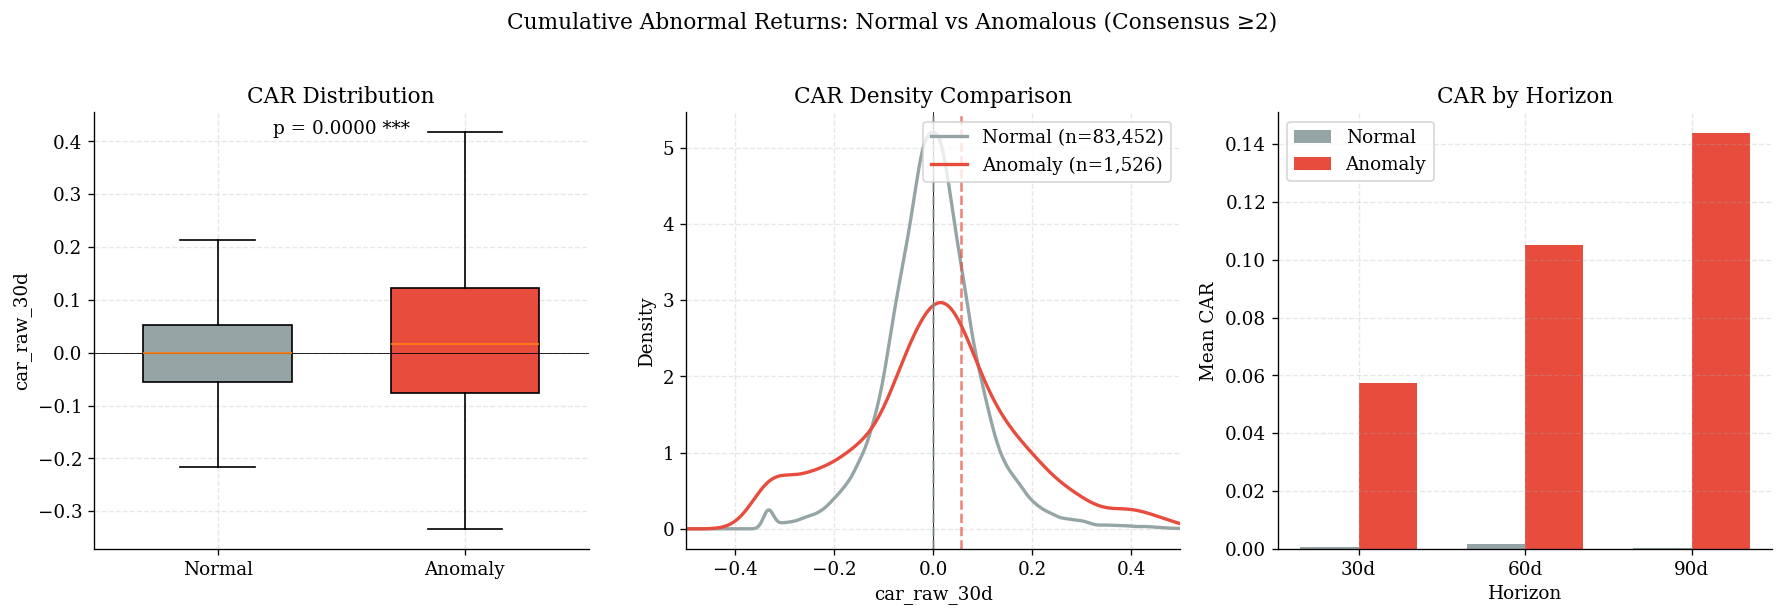

In [30]:
# ============================================================
# FIGURE: CAR Comparison
# ============================================================

# Select main CAR variable
main_car = 'car_raw_30d' if 'car_raw_30d' in df_model.columns else car_cols[0]

normal_car = df_model[df_model[anomaly_col] == 0][main_car].dropna()
anomaly_car = df_model[df_model[anomaly_col] == 1][main_car].dropna()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Boxplot
bp = axes[0].boxplot([normal_car, anomaly_car], labels=['Normal', 'Anomaly'], 
                      patch_artist=True, widths=0.6, showfliers=False)
bp['boxes'][0].set_facecolor(COLORS['normal'])
bp['boxes'][1].set_facecolor(COLORS['anomaly'])
axes[0].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[0].set_ylabel(main_car)
axes[0].set_title('CAR Distribution')

# Add significance annotation
p_val = results_car_df[results_car_df['CAR'] == main_car]['p_value_t'].values[0]
sig_text = f'p = {p_val:.4f}' + (' ***' if p_val < 0.01 else ' **' if p_val < 0.05 else ' *' if p_val < 0.10 else '')
axes[0].text(0.5, 0.95, sig_text, transform=axes[0].transAxes, ha='center', fontsize=11)

# KDE
clip_low, clip_high = -0.5, 0.5
normal_clip = normal_car[(normal_car >= clip_low) & (normal_car <= clip_high)]
anomaly_clip = anomaly_car[(anomaly_car >= clip_low) & (anomaly_car <= clip_high)]

normal_clip.plot.kde(ax=axes[1], color=COLORS['normal'], linewidth=2, label=f'Normal (n={len(normal_car):,})')
anomaly_clip.plot.kde(ax=axes[1], color=COLORS['anomaly'], linewidth=2, label=f'Anomaly (n={len(anomaly_car):,})')
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.5)
axes[1].axvline(normal_car.mean(), color=COLORS['normal'], linestyle='--', alpha=0.7)
axes[1].axvline(anomaly_car.mean(), color=COLORS['anomaly'], linestyle='--', alpha=0.7)
axes[1].set_xlabel(main_car)
axes[1].set_ylabel('Density')
axes[1].set_title('CAR Density Comparison')
axes[1].legend()
axes[1].set_xlim(clip_low, clip_high)

# CAR by horizon
horizons = ['30d', '60d', '90d']
means_normal = []
means_anomaly = []

for h in horizons:
    col = f'car_raw_{h}'
    if col in df_model.columns:
        means_normal.append(df_model[df_model[anomaly_col] == 0][col].mean())
        means_anomaly.append(df_model[df_model[anomaly_col] == 1][col].mean())

x = np.arange(len(horizons))
width = 0.35

axes[2].bar(x - width/2, means_normal, width, label='Normal', color=COLORS['normal'])
axes[2].bar(x + width/2, means_anomaly, width, label='Anomaly', color=COLORS['anomaly'])
axes[2].set_xticks(x)
axes[2].set_xticklabels(horizons)
axes[2].set_xlabel('Horizon')
axes[2].set_ylabel('Mean CAR')
axes[2].set_title('CAR by Horizon')
axes[2].axhline(0, color='black', linestyle='-', linewidth=0.5)
axes[2].legend()

plt.suptitle(f'Cumulative Abnormal Returns: Normal vs Anomalous (Consensus ≥2)', fontsize=13, y=1.02)
plt.tight_layout()
plt.savefig('fig_07_car_comparison.png', dpi=300)
plt.show()

## 7. Characterization of Anomalies

In [31]:
# ============================================================
# TOP ANOMALOUS TRADES
# ============================================================

display_cols = ['Name', 'Party', 'Ticker_Clean', 'Traded', 'Transaction', 
                'score_ensemble', main_car]
display_cols = [c for c in display_cols if c in df_model.columns]

print("Top 20 Most Anomalous Trades:")
print("="*80)
top_anomalies = df_model.nlargest(20, 'score_ensemble')[display_cols]
print(top_anomalies.to_string())

Top 20 Most Anomalous Trades:
                               Name Party Ticker_Clean      Traded Transaction  score_ensemble  car_raw_30d
45914   Mrs. Marjorie Taylor Greene     R         MJNA  2021-02-05        Sale        0.903172    -0.190544
50141                   James Comer     R         SYPR  2020-07-28        Sale        0.860418    -0.333403
49356                James E. Banks     R         PASO  2020-09-01    Purchase        0.859392    -0.333403
49363                James E. Banks     R         PASO  2020-09-01        Sale        0.859392    -0.333403
108679             Mr. Austin Scott     R         PLUG  2013-09-04        Sale        0.750235     0.049960
34023                     Ro Khanna     D         ONCO  2022-06-27    Purchase        0.749141    -0.122581
36495             Michael T. McCaul     R         MOBX  2022-04-20        Sale        0.744986     0.080701
36501             Michael T. McCaul     R         MOBX  2022-04-20        Sale        0.744986     0.08070

In [32]:
# ============================================================
# ANOMALY RATE BY PARTY
# ============================================================

if 'Party' in df_model.columns:
    party_stats = df_model.groupby('Party').agg({
        anomaly_col: ['sum', 'mean', 'count'],
        'score_ensemble': 'mean'
    }).round(4)
    party_stats.columns = ['N_Anomalies', 'Anomaly_Rate', 'Total_Trades', 'Avg_Score']
    party_stats = party_stats.sort_values('Anomaly_Rate', ascending=False)
    
    print("\nAnomaly Rate by Party:")
    print(party_stats)


Anomaly Rate by Party:
       N_Anomalies  Anomaly_Rate  Total_Trades  Avg_Score
Party                                                    
R              865        0.0217         39816     0.0851
D              660        0.0146         45089     0.0782
I                1        0.0123            81     0.0785


In [33]:
# ============================================================
# TOP POLITICIANS BY ANOMALY RATE
# ============================================================

MIN_TRADES = 20  # Minimum trades to be included

if 'Name' in df_model.columns:
    politician_stats = df_model.groupby('Name').agg({
        anomaly_col: ['sum', 'mean'],
        'score_ensemble': 'mean',
        'trade_id': 'count',
        'Party': 'first'
    })
    politician_stats.columns = ['N_Anomalies', 'Anomaly_Rate', 'Avg_Score', 'Total_Trades', 'Party']
    politician_stats = politician_stats[politician_stats['Total_Trades'] >= MIN_TRADES]
    politician_stats = politician_stats.sort_values('Anomaly_Rate', ascending=False)
    
    print(f"\nTop 15 Politicians by Anomaly Rate (min {MIN_TRADES} trades):")
    print(politician_stats.head(15).round(4))


Top 15 Politicians by Anomaly Rate (min 20 trades):
                          N_Anomalies  Anomaly_Rate  Avg_Score  Total_Trades  \
Name                                                                           
Morgan Mcgarvey                     9        0.3462     0.1664            26   
James E. Banks                      8        0.3077     0.2518            26   
Brian Mast                         14        0.2295     0.1569            61   
Daniel Meuser                      14        0.2059     0.1591            68   
Adam Kinzinger                      6        0.1935     0.1696            31   
Moody, Ashley B.                    4        0.1818     0.1896            22   
Austin Scott                       14        0.1609     0.1693            87   
Debbie Wasserman Schultz           10        0.1351     0.1893            74   
Roger W. Marshall                  11        0.1310     0.1625            84   
Michael K. Simpson                  4        0.1111     0.1390     

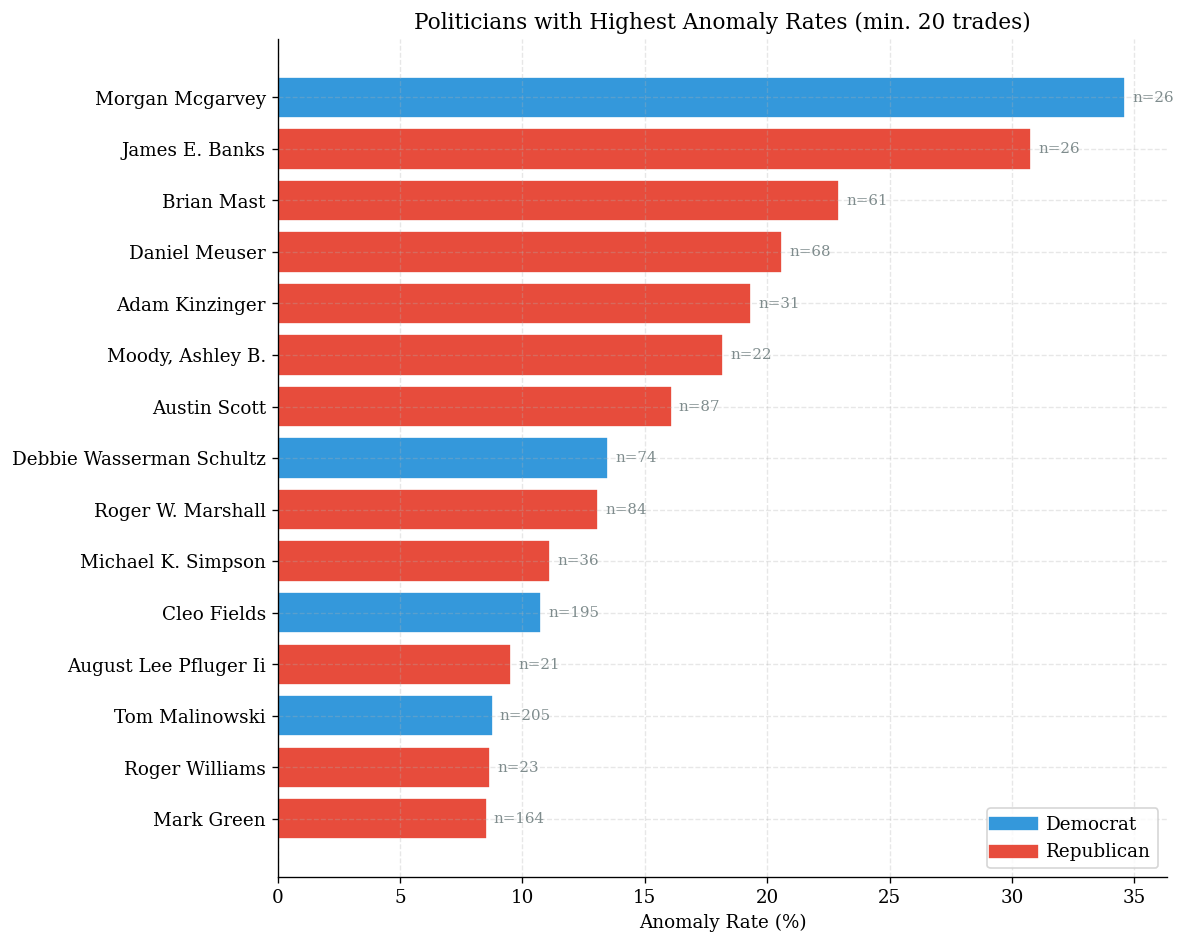

In [34]:
# ============================================================
# FIGURE: Top Politicians
# ============================================================

if 'Name' in df_model.columns:
    top15 = politician_stats.head(15).reset_index()
    
    fig, ax = plt.subplots(figsize=(10, 8))
    
    colors = [COLORS['dem'] if p == 'D' else COLORS['rep'] if p == 'R' else COLORS['secondary'] 
              for p in top15['Party']]
    
    bars = ax.barh(range(len(top15)), top15['Anomaly_Rate'] * 100, color=colors, edgecolor='white')
    ax.set_yticks(range(len(top15)))
    ax.set_yticklabels(top15['Name'])
    ax.set_xlabel('Anomaly Rate (%)')
    ax.set_title(f'Politicians with Highest Anomaly Rates (min. {MIN_TRADES} trades)')
    
    # Add trade count annotations
    for i, row in top15.iterrows():
        ax.annotate(f"n={row['Total_Trades']:.0f}", 
                    xy=(row['Anomaly_Rate']*100 + 0.3, i),
                    va='center', fontsize=9, color=COLORS['secondary'])
    
    # Legend
    legend_elements = [
        Line2D([0], [0], color=COLORS['dem'], lw=8, label='Democrat'),
        Line2D([0], [0], color=COLORS['rep'], lw=8, label='Republican')
    ]
    ax.legend(handles=legend_elements, loc='lower right')
    
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig('fig_08_top_politicians.png', dpi=300)
    plt.show()

In [35]:
# ============================================================
# FEATURE PROFILE: ANOMALIES vs NORMAL
# ============================================================

print("\nFeature Comparison: Normal vs Anomalous Trades")
print("="*70)

feature_comparison = []

for feat in FEATURES_MODEL:
    normal_mean = df_model[df_model[anomaly_col] == 0][feat].mean()
    anomaly_mean = df_model[df_model[anomaly_col] == 1][feat].mean()
    
    # Effect size (Cohen's d)
    pooled_std = df_model[feat].std()
    cohens_d = (anomaly_mean - normal_mean) / pooled_std if pooled_std > 0 else 0
    
    feature_comparison.append({
        'Feature': feat,
        'Normal_Mean': normal_mean,
        'Anomaly_Mean': anomaly_mean,
        'Cohens_d': cohens_d
    })

feature_comp_df = pd.DataFrame(feature_comparison).sort_values('Cohens_d', key=abs, ascending=False)
print(feature_comp_df.round(4).to_string(index=False))


Feature Comparison: Normal vs Anomalous Trades
            Feature  Normal_Mean  Anomaly_Mean  Cohens_d
   realized_vol_30d       0.3254  8.474000e-01    2.0847
abnormal_volume_30d 1106122.8343  4.447449e+07    1.6397
         market_cap  298785.9962  1.310824e+06    1.2119
          beta_252d       0.9932  1.317600e+00    0.7492
       momentum_60d       0.0059  1.760000e-01    0.6999
        momentum_5d      -0.0016  4.620000e-02    0.6681
   volume_ratio_30d       1.1599  6.931500e+00    0.5629
      price_to_book       6.0570  1.782550e+01    0.3741
   amihud_illiq_20d       0.0132  8.955400e+00    0.3003


## 8. Export Results

In [36]:
# ============================================================
# SAVE RESULTS
# ============================================================

# Main results
output_cols = (
    [c for c in id_cols_available if c in df_model.columns] +
    FEATURES_MODEL +
    ['score_if', 'score_lof', 'score_svm', 'score_ensemble',
     'anomaly_if', 'anomaly_lof', 'anomaly_svm', 
     'anomaly_consensus_2', 'anomaly_consensus_3'] +
    [c for c in car_cols_available if c in df_model.columns]
)

output_cols = [c for c in output_cols if c in df_model.columns]

# Save
df_model[output_cols].to_csv('congress_anomaly_results.csv', index=False)
print('✅ Saved: congress_anomaly_results.csv')

# Save politician summary
if 'Name' in df_model.columns:
    politician_stats.to_csv('politician_anomaly_summary.csv')
    print('✅ Saved: politician_anomaly_summary.csv')

# Save CAR results
if len(results_car_df) > 0:
    results_car_df.to_csv('car_validation_results.csv', index=False)
    print('✅ Saved: car_validation_results.csv')

✅ Saved: congress_anomaly_results.csv
✅ Saved: politician_anomaly_summary.csv
✅ Saved: car_validation_results.csv


## 9. Summary

In [37]:
print("\n" + "="*70)
print("ANOMALY DETECTION SUMMARY")
print("="*70)

print(f"\n📊 DATA:")
print(f"   Total trades analyzed: {len(df_model):,}")
print(f"   Features used: {len(FEATURES_MODEL)}")
print(f"   PCA components: {N_COMPONENTS}")

print(f"\n🔍 DETECTION:")
print(f"   Contamination rate: {CONTAMINATION*100:.1f}%")
print(f"   Isolation Forest anomalies: {df_model['anomaly_if'].sum():,}")
print(f"   LOF anomalies: {df_model['anomaly_lof'].sum():,}")
print(f"   One-Class SVM anomalies: {df_model['anomaly_svm'].sum():,}")
print(f"   Consensus (≥2/3): {df_model['anomaly_consensus_2'].sum():,} ({df_model['anomaly_consensus_2'].mean()*100:.2f}%)")

print(f"\n📈 VALIDATION (CAR):")
if len(results_car_df) > 0:
    main_result = results_car_df[results_car_df['CAR'] == main_car].iloc[0]
    print(f"   {main_car}:")
    print(f"     Normal mean: {main_result['Mean_Normal']:.4f}")
    print(f"     Anomaly mean: {main_result['Mean_Anomaly']:.4f}")
    print(f"     Difference: {main_result['Difference']:.4f}")
    print(f"     p-value (t-test): {main_result['p_value_t']:.4f}")

print(f"\n💾 OUTPUTS:")
print(f"   ✅ congress_anomaly_results.csv")
print(f"   ✅ politician_anomaly_summary.csv")
print(f"   ✅ car_validation_results.csv")
print(f"   ✅ 8 figures saved as PNG")

print("\n" + "="*70)
print("🎉 ANALYSIS COMPLETE")
print("="*70)


ANOMALY DETECTION SUMMARY

📊 DATA:
   Total trades analyzed: 84,986
   Features used: 9


NameError: name 'N_COMPONENTS' is not defined